# **Load Independences**

In [24]:
!pip install unidecode

# **Imports**

In [25]:
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import plotly.graph_objects as go
import plotly.express as px

# Function to remove special characters
from unidecode import unidecode

from tqdm.notebook import tqdm, trange

# Feature Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Feature Importance
from sklearn.feature_selection import mutual_info_classif, chi2

# Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Pre Processing
from sklearn.preprocessing import MinMaxScaler



my_palette = sns.diverging_palette(230, 20, as_cmap=False)
sns.set_theme(style="ticks", palette=my_palette)

In [26]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif

# **Data Sets**

## **Download Datasets**

In [27]:
#@title Download Datasets from GDrive

# ESC FREQ 1
!gdown 1IpQuBoxR79tHk8IIAZzwFWtUjzSLr6uZ

# Economic Level
!gdown 1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ

# ESC RENDA
!gdown 1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO

# Regions
!gdown 10uof0LSwNMTcl5w_XZI6B2WyyOFunhcm

Downloading...
From: https://drive.google.com/uc?id=1IpQuBoxR79tHk8IIAZzwFWtUjzSLr6uZ
To: /content/RAIS_ESC_FREQ.csv
100% 315k/315k [00:00<00:00, 6.00MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ
To: /content/results_scrapper_PCDII.csv
100% 698k/698k [00:00<00:00, 9.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO
To: /content/RAIS_IBGE_RENDA.csv
100% 1.64M/1.64M [00:00<00:00, 17.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=10uof0LSwNMTcl5w_XZI6B2WyyOFunhcm
To: /content/regioes_geograficas.xlsx
100% 260k/260k [00:00<00:00, 5.96MB/s]


## **Load Datasets**

In [28]:
rais_freq = pd.read_csv('RAIS_ESC_FREQ.csv', encoding='ISO-8859-1', sep=';')
rais_freq.columns = [key.replace(' ','_').capitalize() for key in rais_freq.columns]

In [29]:
nve_df = pd.read_csv('results_scrapper_PCDII.csv', index_col=0)
nve_df.columns = [key.replace(' ','_').capitalize() for key in nve_df.columns]

In [30]:
rais_renda = pd.read_csv('RAIS_IBGE_RENDA.csv', encoding='ISO-8859-1', sep=';')
rais_renda.columns = [key.replace(' ','_').capitalize() for key in rais_renda.columns]

In [31]:
df_regions = pd.read_excel('/content/regioes_geograficas.xlsx')

# **Pre-Processing**

In [32]:
nve_df = nve_df.rename(columns={key: unidecode(key).replace(' ', '_') for key in nve_df.keys()})
rais_freq = rais_freq.rename(columns={key: unidecode(key).replace(' ', '_') for key in rais_freq.keys()})
rais_renda = rais_renda.rename(columns={key: unidecode(key).replace(' ', '_') for key in rais_renda.keys()})

In [33]:
#@title Get state and city in dataframe
#@markdown Separate State and City from the Municipio attribute

def format_city(city: str):

  city_without_special_charac = unidecode(city)

  city_capitalize = city_without_special_charac.capitalize()

  return city_capitalize


def append_state_and_city(frame, column_name: str):
  frame = frame.copy()

  state_and_city_frame = frame[column_name].apply(lambda x: x.split('-'))

  state = []
  city = []

  for row in state_and_city_frame:
    state.append(row[0])
    city.append(format_city(row[1]))

  frame = frame.drop(columns=[column_name])

  frame['Municipio'] = city

  frame['Estado'] = state

  frame = frame[frame.columns[-2:].tolist() + frame.columns[:-2].tolist()]

  return frame

In [34]:
rais_freq = append_state_and_city(rais_freq, 'Municipio')
rais_renda = append_state_and_city(rais_renda, 'No_municipio')

In [35]:
nve_df['Estado'] = nve_df['Nome'].str.extract(r'\((.*?)\)')

nve_df['Municipio'] = nve_df['Nome'].str.extract(r'^(.*?)(?:\s\()')

nve_df['Municipio'] = nve_df['Municipio'].apply(lambda x : format_city(x))

nve_df = nve_df[nve_df.columns[-2:].tolist() + nve_df.columns[:-2].tolist()]

In [36]:
aux_frame_freq = pd.merge(rais_freq, nve_df[['Estado','Municipio','Codigo','Latitude','Longitude','Populacao_estimada','Nivel_economica']], on=['Estado', 'Municipio'])

order_columns = ['Municipio', 'Estado', 'Codigo', 'Latitude', 'Longitude', 'Analfabeto', 'Ate_5_incompleto',
          '5_completo_fundamental', '6_a_9_fundamental', 'Fundamental_completo',
          'Medio_incompleto', 'Medio_completo', 'Superior_incompleto',
          'Superior_completo', 'Mestrado', 'Doutorado', 'Total', 'Populacao_estimada', 'Nivel_economica']

aux_frame_freq = aux_frame_freq[order_columns]

In [37]:
aux_frame_renda = pd.merge(rais_freq, nve_df[['Estado','Municipio','Codigo']], on=['Estado', 'Municipio'])
aux_frame_renda = aux_frame_renda.drop(columns=['Municipio', 'Estado'])

In [38]:
aux_frame_freq = aux_frame_freq.rename(columns={key: unidecode(key).replace(' ', '_') + '_freq' if key != 'Codigo' else  unidecode(key).replace(' ', '_')  for key in aux_frame_freq.keys()})
aux_frame_renda = aux_frame_renda.rename(columns={key: unidecode(key).replace(' ', '_') + '_renda' if key != 'Codigo' else  unidecode(key).replace(' ', '_') for key in aux_frame_renda.keys()})

In [39]:
df = pd.merge(aux_frame_freq, aux_frame_renda, how='inner', on='Codigo')
df = df.rename(columns={'Latitude_freq':'Latitude', 'Longitude_freq':'Longitude',
                        'Estado_freq':'Estado', 'Municipio_freq':'Municipio',
                        'Nivel_economica_freq':'Nivel_economico'})

<Axes: >

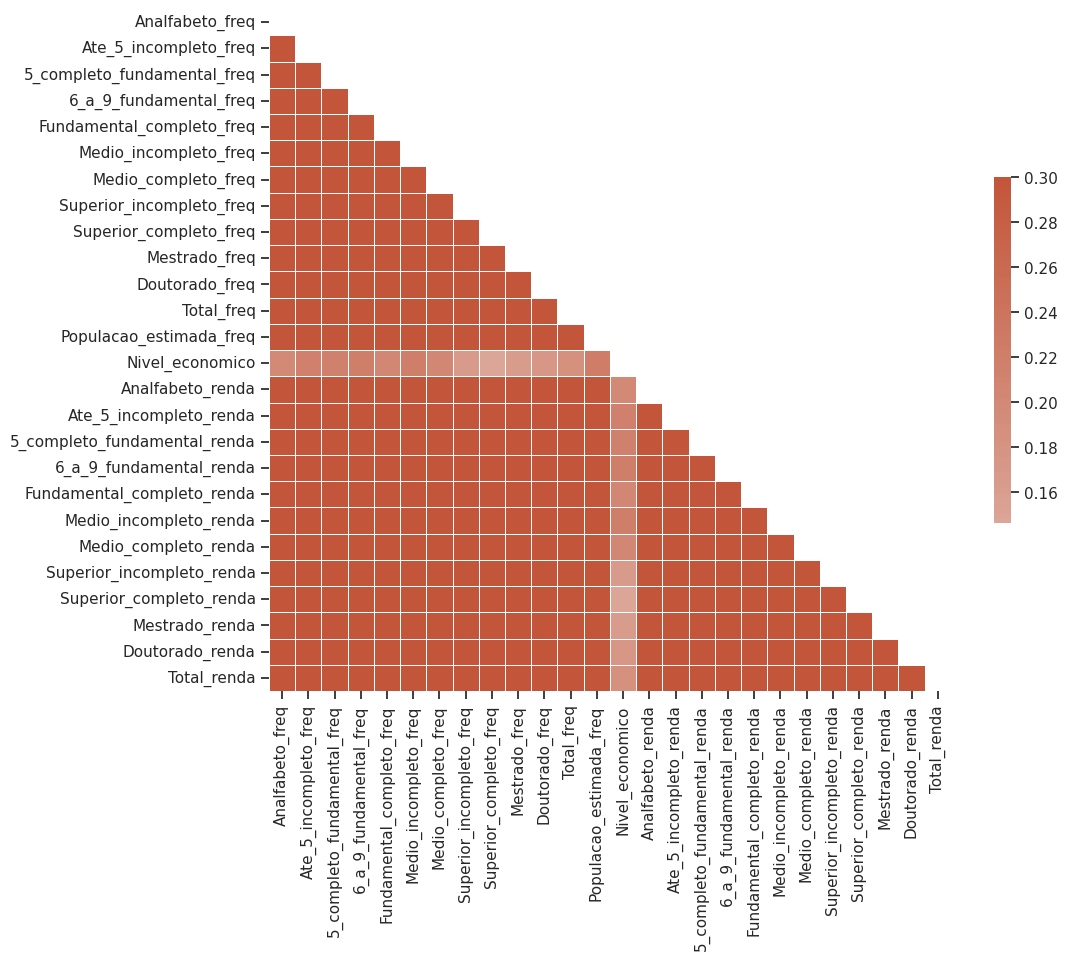

In [40]:
corr = df.iloc[:, 5:].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Classifier with Random Forest**

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from plotly.subplots import make_subplots

## **Build Frame and Functions**

In [76]:
def normalize_frame(frame):
    for key in frame.columns:
        if 'freq' in key:
            frame[key] /= frame['Total_freq']
        elif 'renda' in key:
            frame[key] /= frame['Total_renda']

        if key == 'Populacao_estimada':
            data = frame['Populacao_estimada']
            frame['Populacao_estimada'] = (data - data.min()) / (data.max() - data.min())

    frame = frame.drop(columns=['Total_renda', 'Total_freq'])
    return frame

In [42]:
df = pd.merge(df_regions[['CD_GEOCODI', 'nome_rgint', 'cod_rgint']].rename(columns={'CD_GEOCODI':'Codigo'}), df, how='right', on='Codigo')

In [88]:
state_by_region = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
        'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }

In [94]:
df['Regiao'] = df['Estado'].map(state_by_region)
df = df[['Codigo', 'nome_rgint', 'cod_rgint', 'Regiao','Municipio', 'Estado', 'Latitude',
       'Longitude', 'Analfabeto_freq', 'Ate_5_incompleto_freq',
       '5_completo_fundamental_freq', '6_a_9_fundamental_freq',
       'Fundamental_completo_freq', 'Medio_incompleto_freq',
       'Medio_completo_freq', 'Superior_incompleto_freq',
       'Superior_completo_freq', 'Mestrado_freq', 'Doutorado_freq',
       'Total_freq', 'Populacao_estimada_freq', 'Nivel_economico',
       'Analfabeto_renda', 'Ate_5_incompleto_renda',
       '5_completo_fundamental_renda', '6_a_9_fundamental_renda',
       'Fundamental_completo_renda', 'Medio_incompleto_renda',
       'Medio_completo_renda', 'Superior_incompleto_renda',
       'Superior_completo_renda', 'Mestrado_renda', 'Doutorado_renda',
       'Total_renda']]

## **Country**

In [99]:
X = df.iloc[:, 8:].drop(columns=['Nivel_economico'])
Y = df['Nivel_economico']

In [83]:
#@title Evaluate - MinMax Normalization
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=0))
])

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

accuracies = []
f1_scores = []

for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    pipeline.fit(X_train, Y_train)

    Y_pred = pipeline.predict(X_test)

    accuracies.append(accuracy_score(Y_test, Y_pred))
    f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Acurácia média: {mean_accuracy:.4f}")
print(f"F1-score médio: {mean_f1_score:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Acurácia média: 0.6264
F1-score médio: 0.3902


In [82]:
#@title Evaluate - Total Normalization
clf = RandomForestClassifier(random_state=0)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

accuracies = []
f1_scores = []

for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    X_train = normalize_frame(X_train.copy())
    X_test = normalize_frame(X_test.copy())

    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)

    accuracies.append(accuracy_score(Y_test, Y_pred))
    f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Acurácia média: {mean_accuracy:.4f}")
print(f"F1-score médio: {mean_f1_score:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Acurácia média: 0.6078
F1-score médio: 0.3676


## **Regions**

In [124]:
#@title Evaluate feature performance in each Region - MinMaxNorm
region_and_acc = {}
region_and_f1 = {}
region_feature_importances = {}

num_samples_by_region = []

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for region in tqdm(df['Regiao'].unique()):

    aux_frame = df[df['Regiao'] == region]
    X = aux_frame.iloc[:, 8:].drop(columns=['Nivel_economico'])
    Y = aux_frame['Nivel_economico']

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', RandomForestClassifier(random_state=0))
    ])

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    accuracies = []
    f1_scores = []

    for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits, desc=f'Region :: {region}'):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        pipeline.fit(X_train, Y_train)

        Y_pred = pipeline.predict(X_test)

        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

    region_and_acc[region] = np.array(accuracies)
    region_and_f1[region] = np.array(f1_scores)
    num_samples_by_region.append(len(Y))

for region in region_and_acc:
  region_acc = region_and_acc[region]
  region_f1 = region_and_f1[region]
  print(f'{region}\n\tAcc :: {region_acc.mean():.4} ± {region_acc.std():.4}\n\tF1 :: {region_f1.mean():.4} ± {region_f1.std():.4}')
print()

  0%|          | 0/5 [00:00<?, ?it/s]

Region :: Norte:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Nordeste:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Sudeste:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Sul:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Centro-Oeste:   0%|          | 0/5 [00:00<?, ?it/s]

Norte
	Acc :: 0.7218 ± 0.02944
	F1 :: 0.4289 ± 0.07084
Nordeste
	Acc :: 0.6654 ± 0.02209
	F1 :: 0.4948 ± 0.0636
Sudeste
	Acc :: 0.6296 ± 0.01307
	F1 :: 0.4016 ± 0.05393
Sul
	Acc :: 0.6008 ± 0.03447
	F1 :: 0.357 ± 0.04437
Centro-Oeste
	Acc :: 0.6166 ± 0.01737
	F1 :: 0.425 ± 0.06114



In [125]:
#@title Evaluate feature performance in each Region - MinMaxNorm
tot_region_and_acc = {}
tot_region_and_f1 = {}

num_samples_by_region = []

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for region in tqdm(df['Regiao'].unique()):

    aux_frame = df[df['Regiao'] == region]
    X = aux_frame.iloc[:, 8:].drop(columns=['Nivel_economico'])
    Y = aux_frame['Nivel_economico']

    clf = RandomForestClassifier(random_state=0)

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    accuracies = []
    f1_scores = []

    for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits, desc=f'Region :: {region}'):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        X_train = normalize_frame(X_train.copy())
        X_test = normalize_frame(X_test.copy())

        clf.fit(X_train, Y_train)

        Y_pred = clf.predict(X_test)

        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

    tot_region_and_acc[region] = np.array(accuracies)
    tot_region_and_f1[region] = np.array(f1_scores)
    num_samples_by_region.append(len(Y))

for region in tot_region_and_acc:
  region_acc = tot_region_and_acc[region]
  region_f1 = tot_region_and_f1[region]
  print(f'{region}\n\tAcc :: {region_acc.mean():.4} ± {region_acc.std():.4}\n\tF1 :: {region_f1.mean():.4} ± {region_f1.std():.4}')
print()

  0%|          | 0/5 [00:00<?, ?it/s]

Region :: Norte:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Nordeste:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Sudeste:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Sul:   0%|          | 0/5 [00:00<?, ?it/s]

Region :: Centro-Oeste:   0%|          | 0/5 [00:00<?, ?it/s]

Norte
	Acc :: 0.7287 ± 0.02778
	F1 :: 0.4594 ± 0.06319
Nordeste
	Acc :: 0.6614 ± 0.02698
	F1 :: 0.4552 ± 0.06785
Sudeste
	Acc :: 0.6387 ± 0.01809
	F1 :: 0.4192 ± 0.0843
Sul
	Acc :: 0.5966 ± 0.02803
	F1 :: 0.3484 ± 0.02209
Centro-Oeste
	Acc :: 0.5903 ± 0.03684
	F1 :: 0.391 ± 0.06188



In [152]:
#@title Ratio of Number of Samples per Region and Predictive Power
colors = ['blue', 'red', 'orange', 'green', 'black']

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('[MinMax] - Region and Accuracy', '[Total] - Region and Accuracy')
)

for i, region in enumerate(region_and_acc):
    score = region_and_acc[region].mean()
    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_region[i]],
            mode='markers',
            marker_color=colors[i],
            marker=dict(
                size=10,
                line_width=1,
            ),
            name=region,
            showlegend=False
        ),
        row=1, col=1
    )

for i, region in enumerate(tot_region_and_acc):
    score = tot_region_and_acc[region].mean()
    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_region[i]],
            mode='markers',
            marker_color=colors[i],
            marker=dict(
                size=10,
                line_width=1,
            ),
            name=region,
            showlegend=True
        ),
        row=1, col=2
    )

# Atualizar o layout
fig.update_layout(
    title='Número de Cidades de cada Região por Auracia Media',
    yaxis_title='Número de Cidades',
    xaxis_title='Acuracia',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.add_shape(
    type="line",
    x0=0.6264,
    x1=0.6264,
    y0=0,
    y1=max(num_samples_by_region),
    line=dict(color="black", width=2, dash="dash"),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=0.6264,
    x1=0.6264,
    y0=0,
    y1=max(num_samples_by_region),
    line=dict(color="black", width=2, dash="dash"),
    xref="x2",
    yref="y2"
)

fig.show()

## **State**

In [128]:
#@title Evaluate feature performance in each State - MinMaxNorm
state_and_acc = {}
state_and_f1 = {}
state_feature_importances = {}

num_samples_by_state = []

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for state in tqdm(df['Estado'].unique()):
    if state != 'DF':
      aux_frame = df[df['Estado'] == state]
      X = aux_frame.iloc[:, 8:].drop(columns=['Nivel_economico'])
      Y = aux_frame['Nivel_economico']

      pipeline = Pipeline([
          ('scaler', MinMaxScaler()),
          ('classifier', RandomForestClassifier(random_state=0))
      ])

      n_splits = 5
      skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

      accuracies = []
      f1_scores = []

      for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits, desc=f'state :: {state}'):
          X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
          Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

          pipeline.fit(X_train, Y_train)

          Y_pred = pipeline.predict(X_test)

          accuracies.append(accuracy_score(Y_test, Y_pred))
          f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

      state_and_acc[state] = np.array(accuracies)
      state_and_f1[state] = np.array(f1_scores)
      num_samples_by_state.append(len(Y))

for state in state_and_acc:
  state_acc = state_and_acc[state]
  state_f1 = state_and_f1[state]
  print(f'{state}\n\tAcc :: {state_acc.mean():.4} ± {state_acc.std():.4}\n\tF1 :: {state_f1.mean():.4} ± {state_f1.std():.4}')
print()

  0%|          | 0/27 [00:00<?, ?it/s]

state :: RO:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AC:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AM:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RR:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AP:   0%|          | 0/5 [00:00<?, ?it/s]

state :: TO:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PI:   0%|          | 0/5 [00:00<?, ?it/s]

state :: CE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RN:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PB:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AL:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: BA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MG:   0%|          | 0/5 [00:00<?, ?it/s]

state :: ES:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RJ:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SP:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PR:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SC:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RS:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MS:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MT:   0%|          | 0/5 [00:00<?, ?it/s]

state :: GO:   0%|          | 0/5 [00:00<?, ?it/s]

RO
	Acc :: 0.6056 ± 0.1343
	F1 :: 0.3789 ± 0.107
AC
	Acc :: 0.78 ± 0.1288
	F1 :: 0.4881 ± 0.2645
AM
	Acc :: 0.6282 ± 0.08667
	F1 :: 0.3467 ± 0.06456
RR
	Acc :: 0.5333 ± 0.2667
	F1 :: 0.32 ± 0.16
PA
	Acc :: 0.6048 ± 0.04151
	F1 :: 0.345 ± 0.07785
AP
	Acc :: 0.6167 ± 0.1453
	F1 :: 0.4244 ± 0.1521
TO
	Acc :: 0.8188 ± 0.00324
	F1 :: 0.3511 ± 0.1271
MA
	Acc :: 0.629 ± 0.02824
	F1 :: 0.4159 ± 0.1119
PI
	Acc :: 0.7964 ± 0.02496
	F1 :: 0.4341 ± 0.1019
CE
	Acc :: 0.5814 ± 0.09509
	F1 :: 0.6405 ± 0.1012
RN
	Acc :: 0.5307 ± 0.04696
	F1 :: 0.4963 ± 0.1791
PB
	Acc :: 0.7329 ± 0.05305
	F1 :: 0.4381 ± 0.1041
PE
	Acc :: 0.5845 ± 0.04871
	F1 :: 0.5608 ± 0.128
AL
	Acc :: 0.7237 ± 0.07397
	F1 :: 0.4578 ± 0.1834
SE
	Acc :: 0.6105 ± 0.1017
	F1 :: 0.5015 ± 0.1659
BA
	Acc :: 0.632 ± 0.04933
	F1 :: 0.428 ± 0.08893
MG
	Acc :: 0.6222 ± 0.02091
	F1 :: 0.4923 ± 0.06016
ES
	Acc :: 0.6942 ± 0.08715
	F1 :: 0.4199 ± 0.1271
RJ
	Acc :: 0.5959 ± 0.1442
	F1 :: 0.4862 ± 0.1495
SP
	Acc :: 0.7512 ± 0.02335
	F1 :: 0.4486 ± 0

In [130]:
#@title Evaluate feature performance in each State - MinMaxNorm
tot_state_and_acc = {}
tot_state_and_f1 = {}

num_samples_by_state = []

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  for state in tqdm(df['Estado'].unique()):
    if state != 'DF':
      aux_frame = df[df['Estado'] == state]
      X = aux_frame.iloc[:, 8:].drop(columns=['Nivel_economico'])
      Y = aux_frame['Nivel_economico']

      clf = RandomForestClassifier(random_state=0)

      n_splits = 5
      skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

      accuracies = []
      f1_scores = []

      for train_idx, test_idx in tqdm(skf.split(X, Y), total=n_splits, desc=f'state :: {state}'):
          X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
          Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

          X_train = normalize_frame(X_train.copy())
          X_test = normalize_frame(X_test.copy())

          clf.fit(X_train, Y_train)

          Y_pred = clf.predict(X_test)

          accuracies.append(accuracy_score(Y_test, Y_pred))
          f1_scores.append(f1_score(Y_test, Y_pred, average='macro'))

      tot_state_and_acc[state] = np.array(accuracies)
      tot_state_and_f1[state] = np.array(f1_scores)
      num_samples_by_state.append(len(Y))

for state in tot_state_and_acc:
  state_acc = tot_state_and_acc[state]
  state_f1 = tot_state_and_f1[state]
  print(f'{state}\n\tAcc :: {state_acc.mean():.4} ± {state_acc.std():.4}\n\tF1 :: {state_f1.mean():.4} ± {state_f1.std():.4}')
print()

  0%|          | 0/27 [00:00<?, ?it/s]

state :: RO:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AC:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AM:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RR:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AP:   0%|          | 0/5 [00:00<?, ?it/s]

state :: TO:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PI:   0%|          | 0/5 [00:00<?, ?it/s]

state :: CE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RN:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PB:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: AL:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SE:   0%|          | 0/5 [00:00<?, ?it/s]

state :: BA:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MG:   0%|          | 0/5 [00:00<?, ?it/s]

state :: ES:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RJ:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SP:   0%|          | 0/5 [00:00<?, ?it/s]

state :: PR:   0%|          | 0/5 [00:00<?, ?it/s]

state :: SC:   0%|          | 0/5 [00:00<?, ?it/s]

state :: RS:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MS:   0%|          | 0/5 [00:00<?, ?it/s]

state :: MT:   0%|          | 0/5 [00:00<?, ?it/s]

state :: GO:   0%|          | 0/5 [00:00<?, ?it/s]

RO
	Acc :: 0.5556 ± 0.1165
	F1 :: 0.3388 ± 0.1223
AC
	Acc :: 0.73 ± 0.06782
	F1 :: 0.396 ± 0.07327
AM
	Acc :: 0.7256 ± 0.08421
	F1 :: 0.3959 ± 0.1003
RR
	Acc :: 0.6667 ± 0.0
	F1 :: 0.4533 ± 0.1067
PA
	Acc :: 0.5688 ± 0.05676
	F1 :: 0.2914 ± 0.07527
AP
	Acc :: 0.5 ± 0.1491
	F1 :: 0.2822 ± 0.09828
TO
	Acc :: 0.8188 ± 0.00324
	F1 :: 0.342 ± 0.1117
MA
	Acc :: 0.648 ± 0.03899
	F1 :: 0.374 ± 0.1074
PI
	Acc :: 0.7736 ± 0.02951
	F1 :: 0.3147 ± 0.02913
CE
	Acc :: 0.5489 ± 0.02031
	F1 :: 0.4155 ± 0.1061
RN
	Acc :: 0.5924 ± 0.03181
	F1 :: 0.4722 ± 0.1429
PB
	Acc :: 0.7149 ± 0.01771
	F1 :: 0.2994 ± 0.05282
PE
	Acc :: 0.5953 ± 0.073
	F1 :: 0.4447 ± 0.1378
AL
	Acc :: 0.6426 ± 0.1051
	F1 :: 0.4332 ± 0.218
SE
	Acc :: 0.6771 ± 0.07343
	F1 :: 0.5516 ± 0.1318
BA
	Acc :: 0.6296 ± 0.06468
	F1 :: 0.38 ± 0.08965
MG
	Acc :: 0.6174 ± 0.01046
	F1 :: 0.4791 ± 0.06223
ES
	Acc :: 0.6667 ± 0.07365
	F1 :: 0.3981 ± 0.09306
RJ
	Acc :: 0.5064 ± 0.04939
	F1 :: 0.3452 ± 0.09287
SP
	Acc :: 0.7671 ± 0.0434
	F1 :: 0.4912 ± 

In [137]:
#@title Ratio of Number of Samples per State and Predictive Power
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('[MinMax] - Region and Accuracy', '[Total] - Region and Accuracy')
)

for i, state in enumerate(state_and_acc):
    score = state_and_acc[state].mean()

    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_state[i]],
            mode='markers',
            marker=dict(
                size=10,
                line_width=1,
                color='blue'
            ),
            hovertext=[state],
            showlegend=False
        ),
        row=1, col=1
    )

for i, state in enumerate(tot_state_and_acc):
    score = tot_state_and_acc[state].mean()

    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_state[i]],
            mode='markers',
            marker=dict(
                size=10,
                line_width=1,
                color='blue'
            ),
            hovertext=[state],
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_layout(
    title='Número de Cidades de cada Região por Auracia Media',
    yaxis_title='Número de Cidades',
    xaxis_title='Acuracia',
    width=1100,
    height=500,
    template='plotly_white'
)

fig.show()


In [148]:
#@title Ratio of Number of Samples per State and Predictive Power
region_colors = {
    'Norte': 'blue',
    'Nordeste': 'red',
    'Centro-Oeste': 'green',
    'Sudeste': 'orange',
    'Sul': 'purple'
}

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('[MinMax] - Region and Accuracy', '[Total] - Region and Accuracy')
)

region_legend_added = {}

for i, state in enumerate(state_and_acc):
    score = state_and_acc[state].mean()

    region = state_by_region.get(state, 'Desconhecida')
    color = region_colors.get(region, 'black')

    show_legend = region not in region_legend_added
    if show_legend:
        region_legend_added[region] = True

    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_state[i]],
            mode='markers',
            marker=dict(
                size=10,
                line_width=1,
                color=color
            ),
            hovertext=[f"{state} - {region}"],
            showlegend=show_legend,
            name=region,
            legendgroup=region
        ),
        row=1, col=1
    )

for i, state in enumerate(tot_state_and_acc):
    score = tot_state_and_acc[state].mean()

    region = state_by_region.get(state, 'Desconhecida')
    color = region_colors.get(region, 'black')

    show_legend = region not in region_legend_added
    if show_legend:
        region_legend_added[region] = True

    fig.add_trace(
        go.Scatter(
            x=[score],
            y=[num_samples_by_state[i]],
            mode='markers',
            marker=dict(
                size=10,
                line_width=1,
                color=color
            ),
            hovertext=[f"{state} - {region}"],
            showlegend=show_legend,
            name=region,
            legendgroup=region
        ),
        row=1, col=2
    )

fig.update_layout(
    title='Número de Cidades de cada Região por Auracia Media',
    yaxis_title='Número de Cidades',
    xaxis_title='Acuracia',
    width=1100,
    height=500,
    template='plotly_white'
)

fig.add_shape(
    type="line",
    x0=0.6264,
    x1=0.6264,
    y0=0,
    y1=max(num_samples_by_state),
    line=dict(color="black", width=2, dash="dash"),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=0.6264,
    x1=0.6264,
    y0=0,
    y1=max(num_samples_by_state),
    line=dict(color="black", width=2, dash="dash"),
    xref="x2",
    yref="y2"
)

fig.show()